# Lens Distorsion on camera

From youtube video on [Image formation: pixels: lens distortion](https://www.youtube.com/watch?v=hY4Dvw2A_PI&list=PLhwIOYE-ldwL6h-peJADfNm8bbO3GlKEy&index=14)


In [13]:
! pip install griddify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 15.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 15.0 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.9 MB/s  0:00:03m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10/10 [griddify]/10 [numba]-learn]


In [3]:
# Image warping routines
import numpy as np
from PIL import Image

def quad_as_rect(quad):
    if quad[0] != quad[2]: return False
    if quad[1] != quad[7]: return False
    if quad[4] != quad[6]: return False
    if quad[3] != quad[5]: return False
    return True

def quad_to_rect(quad):
    assert(len(quad) == 8)
    assert(quad_as_rect(quad))
    return (quad[0], quad[1], quad[4], quad[3])

def rect_to_quad(rect):
    assert(len(rect) == 4)
    return (rect[0], rect[1], rect[0], rect[3], rect[2], rect[3], rect[2], rect[1])

def shape_to_rect(shape):
    assert(len(shape) == 2)
    return (0, 0, shape[0], shape[1])

def griddify(rect, w_div, h_div):
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]
    x_step = w / float(w_div)
    y_step = h / float(h_div)
    y = rect[1]
    grid_vertex_matrix = []
    for _ in range(h_div + 1):
        grid_vertex_matrix.append([])
        x = rect[0]
        for _ in range(w_div + 1):
            grid_vertex_matrix[-1].append([int(x), int(y)])
            x += x_step
        y += y_step
    grid = np.array(grid_vertex_matrix)
    return grid

def distort_grid(org_grid, max_shift):
    new_grid = np.copy(org_grid)
    x_min = np.min(new_grid[:, :, 0])
    y_min = np.min(new_grid[:, :, 1])
    x_max = np.max(new_grid[:, :, 0])
    y_max = np.max(new_grid[:, :, 1])
    new_grid += np.random.randint(- max_shift, max_shift + 1, new_grid.shape)
    new_grid[:, :, 0] = np.maximum(x_min, new_grid[:, :, 0])
    new_grid[:, :, 1] = np.maximum(y_min, new_grid[:, :, 1])
    new_grid[:, :, 0] = np.minimum(x_max, new_grid[:, :, 0])
    new_grid[:, :, 1] = np.minimum(y_max, new_grid[:, :, 1])
    return new_grid

def grid_to_mesh(src_grid, dst_grid):
    assert(src_grid.shape == dst_grid.shape)
    mesh = []
    for i in range(src_grid.shape[0] - 1):
        for j in range(src_grid.shape[1] - 1):
            src_quad = [src_grid[i    , j    , 0], src_grid[i    , j    , 1],
                        src_grid[i + 1, j    , 0], src_grid[i + 1, j    , 1],
                        src_grid[i + 1, j + 1, 0], src_grid[i + 1, j + 1, 1],
                        src_grid[i    , j + 1, 0], src_grid[i    , j + 1, 1]]
            dst_quad = [dst_grid[i    , j    , 0], dst_grid[i    , j    , 1],
                        dst_grid[i + 1, j    , 0], dst_grid[i + 1, j    , 1],
                        dst_grid[i + 1, j + 1, 0], dst_grid[i + 1, j + 1, 1],
                        dst_grid[i    , j + 1, 0], dst_grid[i    , j + 1, 1]]
            dst_rect = quad_to_rect(dst_quad)
            mesh.append([dst_rect, src_quad])
    return mesh

In [ ]:
import matplotlib.pyplot as plt
import cv2 as cv

X dim :  720
Y dim :  1280
Mid :  640


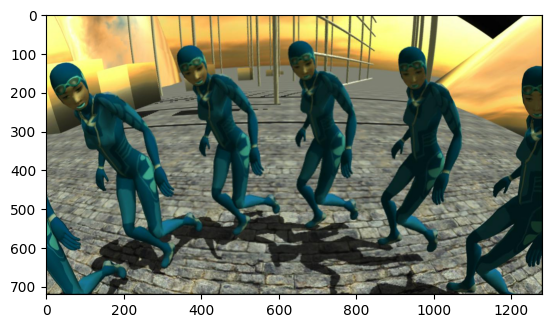

In [ ]:
# load distorted image 
# img = cv.imread("./images/lensdistortion.jpg", cv.IMREAD_GRAYSCALE)
img = Image.open("./images/lensdistortion.jpg")

ydim, xdim = img.size
mid = round(max(xdim, ydim)/2) # I need the middle to compute relative distance for distortion

print("X dim : ", xdim)
print("Y dim : ", ydim)
print("Mid : ", mid)

plt.imshow(img)
plt.show()

In [15]:
# define sampling lattice 
n = 100 # latice sampling 
destination = griddify(shape_to_rect(img.size), n, n)
source = destination

print(destination)

k = 0.0000009
destination = destination - mid

print(destination)

[[[   0    0]
  [  12    0]
  [  25    0]
  ...
  [1254    0]
  [1267    0]
  [1279    0]]

 [[   0    7]
  [  12    7]
  [  25    7]
  ...
  [1254    7]
  [1267    7]
  [1279    7]]

 [[   0   14]
  [  12   14]
  [  25   14]
  ...
  [1254   14]
  [1267   14]
  [1279   14]]

 ...

 [[   0  705]
  [  12  705]
  [  25  705]
  ...
  [1254  705]
  [1267  705]
  [1279  705]]

 [[   0  712]
  [  12  712]
  [  25  712]
  ...
  [1254  712]
  [1267  712]
  [1279  712]]

 [[   0  720]
  [  12  720]
  [  25  720]
  ...
  [1254  720]
  [1267  720]
  [1279  720]]]
[[[-640 -640]
  [-628 -640]
  [-615 -640]
  ...
  [ 614 -640]
  [ 627 -640]
  [ 639 -640]]

 [[-640 -633]
  [-628 -633]
  [-615 -633]
  ...
  [ 614 -633]
  [ 627 -633]
  [ 639 -633]]

 [[-640 -626]
  [-628 -626]
  [-615 -626]
  ...
  [ 614 -626]
  [ 627 -626]
  [ 639 -626]]

 ...

 [[-640   65]
  [-628   65]
  [-615   65]
  ...
  [ 614   65]
  [ 627   65]
  [ 639   65]]

 [[-640   72]
  [-628   72]
  [-615   72]
  ...
  [ 614   72]
  [ 62

In [16]:
for i in range(n+1):
    for j in range(n+1):
        x = destination[i,j,0]
        y = destination[i,j,1]
        r = np.sqrt(x**2 + y**2)

        source[i,j,0] = x * (1 + k*r**2)
        source[i,j,1] = y * (1 + k*r**2)

In [17]:
destination = destination + mid
destination = destination.astype(int)

source = source + mid
source = source.astype(int)

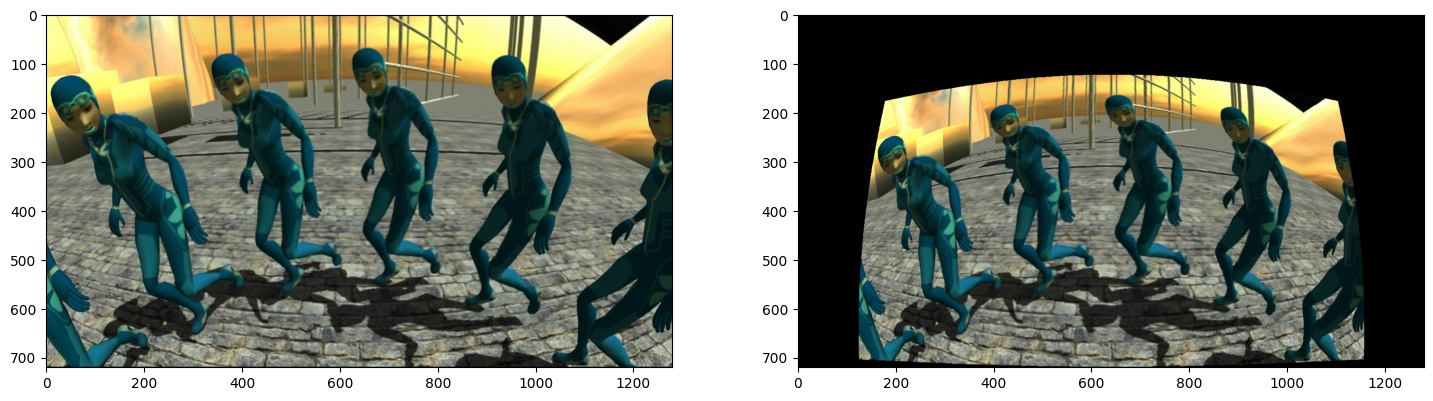

In [18]:
# Warping image 
mesh = grid_to_mesh(source, destination)
image_undsitorted = img.transform(img.size, Image.MESH, mesh)

plt.figure(figsize=(ydim/72, xdim/72))

plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(image_undsitorted)

plt.show()
